In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [2]:
actions = ['TakeOff', 'Up', 'Down', 'RightTurn', 'LeftTurn', 'Land']

In [3]:
# 시퀀스 데이터 합치기
data = np.concatenate([
    np.load('./dataset/seq_TakeOff_1690000686.npy'),
    np.load('./dataset/seq_Up_1690000686.npy'),
    np.load('./dataset/seq_Down_1690000686.npy'),
    np.load('./dataset/seq_RightTurn_1690000686.npy'),
    np.load('./dataset/seq_LeftTurn_1690000686.npy'),
    np.load('./dataset/seq_Land_1690000686.npy')
], axis = 0)

In [4]:
data.shape

(5206, 30, 100)

In [5]:
# data의 마지막 값이 라벨이므로 x_data와 labels로 나누기
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

In [6]:
print(x_data.shape)
print(labels.shape)

(5206, 30, 99)
(5206,)


In [7]:
# One-hot encoding 진행 
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(5206, 6)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# 데이터의 90%를 train용으로 나머지 10%를 테스트용으로 사용
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

In [10]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4685, 30, 99) (4685, 6)
(521, 30, 99) (521, 6)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [12]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # input_shape = [30, 99], 30->윈도우의 크기, 99->랜드마크, visibility, 각도
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 44,262
Trainable params: 44,262
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [15]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
144/147 [============================>.] - ETA: 0s - loss: 18.8218 - acc: 0.4494
Epoch 1: val_acc improved from -inf to 0.62380, saving model to models\model.h5
147/147 [==============================] - 4s 14ms/step - loss: 18.6233 - acc: 0.4519 - val_loss: 5.2104 - val_acc: 0.6238 - lr: 0.0010
Epoch 2/200
143/147 [============================>.] - ETA: 0s - loss: 15.8015 - acc: 0.6014
Epoch 2: val_acc did not improve from 0.62380
147/147 [==============================] - 2s 11ms/step - loss: 16.1975 - acc: 0.5934 - val_loss: 29.7120 - val_acc: 0.4184 - lr: 0.0010
Epoch 3/200
142/147 [===========================>..] - ETA: 0s - loss: 10.7634 - acc: 0.4892
Epoch 3: val_acc improved from 0.62380 to 0.68330, saving model to models\model.h5
147/147 [==============================] - 2s 11ms/step - loss: 10.5730 - acc: 0.4928 - val_loss: 2.6702 - val_acc: 0.6833 - lr: 0.0010
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 2.0953 - acc: 0.6794
Epoch 4: va

In [16]:
import matplotlib.pyplot as plt

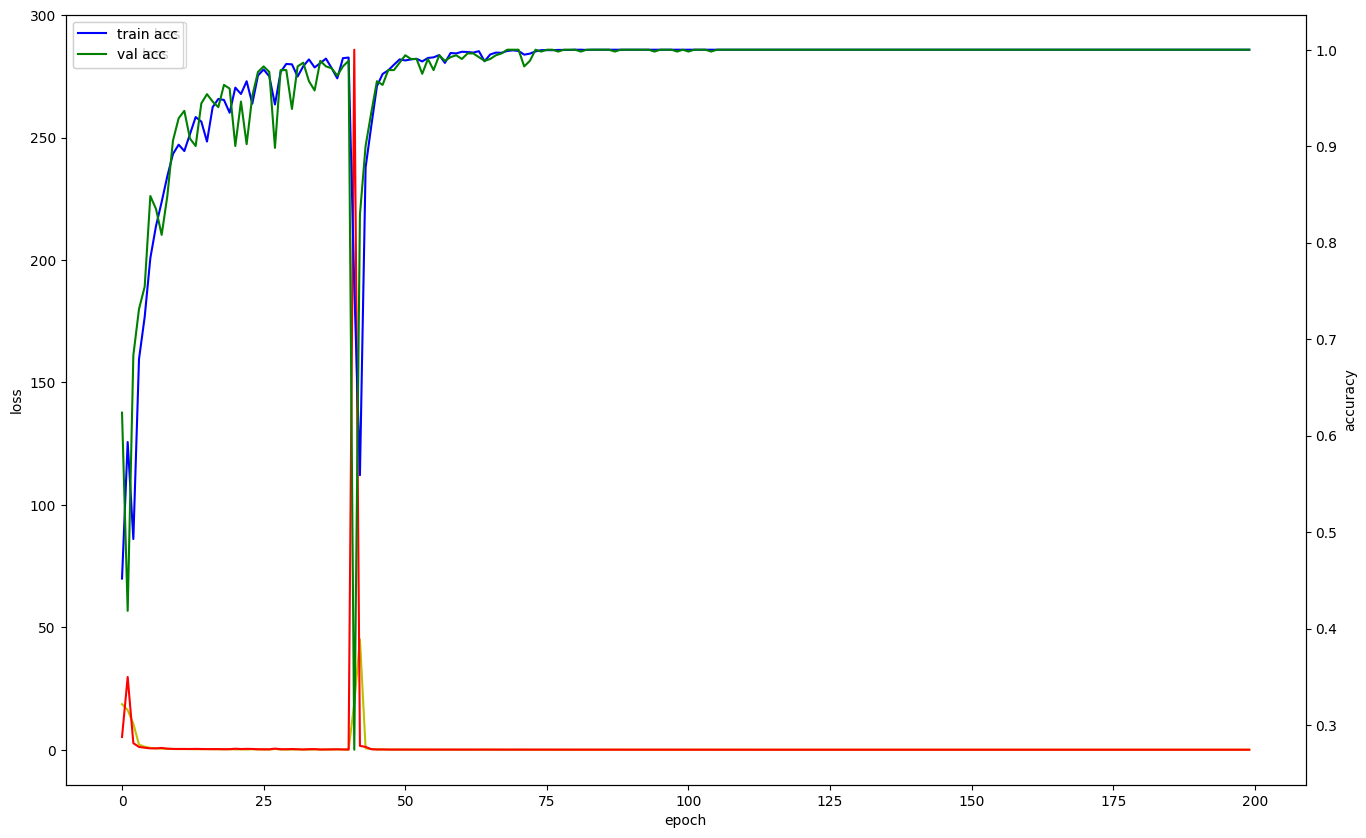

In [17]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()
# 파란 그래프 : train 정확도
# 초록 그래프 : val 정확도
# 노란 그래프 : train loss
# 빨간 그래프 : val loss

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

In [19]:
model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

17/17 [==============================] - 0s 4ms/step


array([[[428,   0],
        [  0,  93]],

       [[425,   0],
        [  0,  96]],

       [[453,   0],
        [  0,  68]],

       [[434,   0],
        [  0,  87]],

       [[424,   0],
        [  0,  97]],

       [[441,   0],
        [  0,  80]]], dtype=int64)